In [27]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry.polygon import Polygon, Point
from tqdm import tqdm
import pandas as pd
import math

import warnings
import os
# import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [28]:
def rotate_vector(orig_vector, degree, origin=np.array([0, 0])):
    """
    Rotate a 2-D vector (point) by some given degree. Optionally around a specified origin besides (0,0).
    Supports multiple points.

    Parameters
    ----------
    orig_vector : np.array
                 Original vector(s) of size (2,) or (n,2)
    degree : float
             Counter-clockwise rotation amount in degrees
    origin : np.array
            Origin of rotation
    """
    vector = np.array(orig_vector)
    origin = np.array(origin)

    if vector.ndim == 1:
        vector = np.expand_dims(vector, axis=0)
    vector = vector - origin  # center of circle

    theta = np.radians(degree)
    rotation_matrix = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    )

    vector = (rotation_matrix @ vector.T).T
    vector = vector + origin
    return vector

def reock_score(geom):
    geom_area = geom.geometry.area[0]
    min_circle = geom.geometry.minimum_bounding_circle()[0]
    min_circle_area = min_circle.area
    reock_score = geom_area / min_circle_area
    return reock_score

# Arguments

In [29]:
data_path = "../data/mggg-states/"
output_dir = "../output/"
run_name = "moving_knife"
seed = 42

pop = "POP20"
d_votes = "USH20_D"
r_votes = "USH20_R"
state = "ct_2020"
n_districts = 5

In [30]:
degrees = np.array(range(0, 360, 10), dtype="f")
radians = np.radians(degrees)
radius_slopes = np.sin(radians)/np.cos(radians)
tangent_slopes = -(1 / radius_slopes)

C:\Users\yagne\AppData\Local\Temp\ipykernel_11620\2537156120.py:4: RuntimeWarning: divide by zero encountered in divide
  tangent_slopes = -(1 / radius_slopes)


# Step 0
## Initial File

In [31]:
voting_precincts = gpd.read_file(f"../redistricting/data_prep/output/{state}/")

orig_columns = list(voting_precincts.columns)
voting_precincts[d_votes] = voting_precincts[d_votes].fillna(0)
voting_precincts[r_votes] = voting_precincts[r_votes].fillna(0)
voting_precincts[pop] = voting_precincts[pop].fillna(0)
orig_voting = voting_precincts[[d_votes, r_votes]].sum() / (
    voting_precincts[[d_votes, r_votes]].sum().sum()
)

voting_precincts["REPRESENTATIVE_POINT"] = voting_precincts.centroid
voting_precincts["RP_LON"] = voting_precincts["REPRESENTATIVE_POINT"].apply(
    lambda p: p.x
)
voting_precincts["RP_LAT"] = voting_precincts["REPRESENTATIVE_POINT"].apply(
    lambda p: p.y
)

target_pop_ratio = 1 / n_districts
target_pop = target_pop_ratio * voting_precincts[pop].sum()
print('Target Population:', target_pop)

Target Population: 721188.8


0.4929

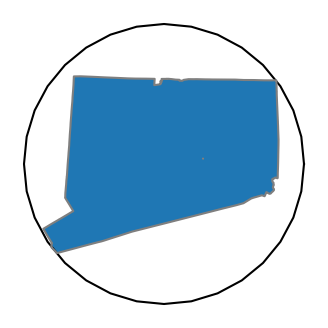

In [32]:
df_1 = voting_precincts.copy().reset_index(drop=True)
df_1["ORIGINAL_INDEX_"] = df_1.index
df_1["DISTRICT_"] = 0  # Original
df_1["INDEX_"] = df_1.index
points = df_1[["RP_LON", "RP_LAT"]].to_numpy()

# Create circle of remaining pieces
state_dissolved = df_1.dissolve()
state_min_radius = state_dissolved.geometry.minimum_bounding_radius()[0]
state_min_circle = state_dissolved.geometry.minimum_bounding_circle()[0]
state_min_circle_o = state_min_circle.centroid
origin = np.array([state_min_circle_o.x, state_min_circle_o.y])


x_min, x_max  = np.min(state_min_circle.exterior.coords.xy[0]),np.max(state_min_circle.exterior.coords.xy[0])
y_min, y_max  = np.min(state_min_circle.exterior.coords.xy[1]),np.max(state_min_circle.exterior.coords.xy[1])


fig, ax = plt.subplots(figsize=(4,4))
circumference_points = state_min_radius*np.vstack([np.cos(radians), np.sin(radians)]).T
plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="black")

ax.set_axis_off()
diss = df_1.dissolve()
diss.boundary.plot(ax=ax, color="tab:gray")
diss.plot(ax=ax, color="C0")
round(reock_score(diss),4)

In [33]:
holder = []
step = 1
# Loop through each degree point
degrees_tracker = []
for degree in tqdm(degrees):
    df_1 = df_1.sort_values(by="INDEX_").reset_index(drop=True)
    df_1["NEW_DISTRICT_"] = 0

    rotated_points = rotate_vector(points, 360 - degree, origin)
    df_1["ROTATED_LON"] = rotated_points[:, 0]
    df_1 = df_1.sort_values(by="ROTATED_LON").reset_index(drop=True)
    i = 0
    captured_pop = 0
    while captured_pop < target_pop:
        captured_pop += df_1.loc[i, pop]
        i += 1
    # Check for Inclusivity
    pop_check1 = df_1.iloc[: i - 1][pop].sum()
    pop_check2 = df_1.iloc[:i][pop].sum()
    inclusive = (
        True
        if abs(pop_check1 - target_pop) > abs(pop_check2 - target_pop)
        else False
    )
    if inclusive:
        df_1.loc[: i - 1, "NEW_DISTRICT_"] = 1
    else:
        df_1.loc[: i - 2, "NEW_DISTRICT_"] = 1
    # df_1.dissolve(by="NEW_DISTRICT_").reset_index().plot(column="NEW_DISTRICT_")
    

    df_a = df_1.loc[df_1["NEW_DISTRICT_"] == 1].copy().reset_index(drop=True)
    df_b = df_1.loc[df_1["NEW_DISTRICT_"] != 1].copy().reset_index(drop=True)

    df_a_compactness = reock_score(df_a.dissolve())
    df_b_compactness = reock_score(df_b.dissolve())
    mean_compactness = (df_a_compactness + df_b_compactness) / 2

    degrees_tracker.append(
        {
            "degree": degree,
            "pieces": i,
            "inclusive": inclusive,
            "population": captured_pop,
            "compactness": mean_compactness,
        }
    )

degrees_tracker = pd.DataFrame(degrees_tracker)
degrees_tracker = degrees_tracker.sort_values(
    by="compactness", ascending=False
).reset_index(drop=True)
optimal_choice = degrees_tracker.iloc[0]

df_1 = df_1.sort_values(by="INDEX_").reset_index(drop=True)
rotated_points = rotate_vector(points, 360 - optimal_choice["degree"], origin)
df_1["ROTATED_LON"] = rotated_points[:, 0]
df_1 = df_1.sort_values(by="ROTATED_LON").reset_index(drop=True)
if optimal_choice["inclusive"]:
    df_1.loc[: optimal_choice["pieces"] - 1, "DISTRICT_"] = step
else:
    df_1.loc[: optimal_choice["pieces"] - 2, "DISTRICT_"] = step

holder.append(df_1.loc[df_1["DISTRICT_"] == step])
df_2 = df_1.loc[df_1["DISTRICT_"] == 0]  # So far unused.
step += 1

100%|██████████| 36/36 [00:31<00:00,  1.13it/s]


0.572716078540072
60.0 210.0


0.6314

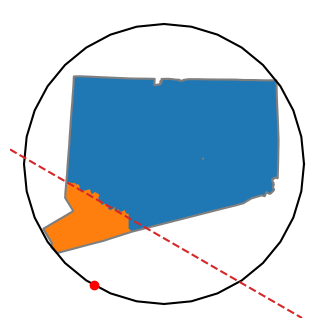

In [34]:
optimal_choice = degrees_tracker.iloc[0]
print(optimal_choice['compactness'])
piece = optimal_choice['pieces'] - 2 + (1 * optimal_choice['inclusive'])
ax_line_lon = df_1.loc[piece]['RP_LON']
ax_line_lat = df_1.loc[piece]['RP_LAT']

fig, ax = plt.subplots(figsize=(4,4))
circumference_points = state_min_radius*np.vstack([np.cos(radians), np.sin(radians)]).T

ax.set_axis_off()
diss.boundary.plot(ax=ax, color="tab:gray")
diss_1 = df_1.dissolve()
diss_1.plot(ax=ax, color="C1")

diss_2 = df_2.dissolve()
diss_2.plot(ax=ax, color="C0")

d_ =  optimal_choice['degree']
slope = tangent_slopes[np.where(degrees == d_)][0]
# ax.axline((origin[0], origin[1]), slope=-1/slope, color='C3', linestyle="--")

d_2 = 270 - d_
d_2 = d_2 + 360.0 if d_2 < 0 else d_2
print(d_,d_2)
tangent_point = [state_min_radius * np.sin(radians[np.where(degrees == d_2)])[0],state_min_radius * np.cos(radians[np.where(degrees == d_2)])[0]] 
tangent_point = np.array(tangent_point) + origin
plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="black")
ax.axline((ax_line_lon, ax_line_lat), slope=slope, color='C3', linestyle="--")

ax.plot(tangent_point[0],tangent_point[1],'ro')


# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
round(reock_score(diss_2),4)

In [35]:

step = 2
# Loop through each degree point

df_2["INDEX_"] = df_2.index
points = df_2[["RP_LON", "RP_LAT"]].to_numpy()

# Create circle of remaining pieces
state_dissolved = df_2.dissolve()
state_min_radius = state_dissolved.geometry.minimum_bounding_radius()[0]
state_min_circle = state_dissolved.geometry.minimum_bounding_circle()[0]
state_min_circle_o = state_min_circle.centroid
origin = np.array([state_min_circle_o.x, state_min_circle_o.y])



degrees_tracker = []
for degree in tqdm(degrees):
    df_2 = df_2.sort_values(by="INDEX_").reset_index(drop=True)
    df_2["NEW_DISTRICT_"] = 0

    rotated_points = rotate_vector(points, 360 - degree, origin)
    df_2["ROTATED_LON"] = rotated_points[:, 0]
    df_2 = df_2.sort_values(by="ROTATED_LON").reset_index(drop=True)
    i = 0
    captured_pop = 0
    while captured_pop < target_pop:
        captured_pop += df_2.loc[i, pop]
        i += 1
    # Check for Inclusivity
    pop_check1 = df_2.iloc[: i - 1][pop].sum()
    pop_check2 = df_2.iloc[:i][pop].sum()
    inclusive = (
        True
        if abs(pop_check1 - target_pop) > abs(pop_check2 - target_pop)
        else False
    )
    if inclusive:
        df_2.loc[: i - 1, "NEW_DISTRICT_"] = 1
    else:
        df_2.loc[: i - 2, "NEW_DISTRICT_"] = 1
    # df_2.dissolve(by="NEW_DISTRICT_").reset_index().plot(column="NEW_DISTRICT_")
    

    df_a = df_2.loc[df_2["NEW_DISTRICT_"] == 1].copy().reset_index(drop=True)
    df_b = df_2.loc[df_2["NEW_DISTRICT_"] != 1].copy().reset_index(drop=True)

    df_a_compactness = reock_score(df_a.dissolve())
    df_b_compactness = reock_score(df_b.dissolve())
    mean_compactness = (df_a_compactness + df_b_compactness) / 2

    degrees_tracker.append(
        {
            "degree": degree,
            "pieces": i,
            "inclusive": inclusive,
            "population": captured_pop,
            "compactness": mean_compactness,
        }
    )

degrees_tracker = pd.DataFrame(degrees_tracker)
degrees_tracker = degrees_tracker.sort_values(
    by="compactness", ascending=False
).reset_index(drop=True)
optimal_choice = degrees_tracker.iloc[0]

df_2 = df_2.sort_values(by="INDEX_").reset_index(drop=True)
rotated_points = rotate_vector(points, 360 - optimal_choice["degree"], origin)
df_2["ROTATED_LON"] = rotated_points[:, 0]
df_2 = df_2.sort_values(by="ROTATED_LON").reset_index(drop=True)
if optimal_choice["inclusive"]:
    df_2.loc[: optimal_choice["pieces"] - 1, "DISTRICT_"] = step
else:
    df_2.loc[: optimal_choice["pieces"] - 2, "DISTRICT_"] = step

holder.append(df_2.loc[df_2["DISTRICT_"] == step])
df_3 = df_2.loc[df_2["DISTRICT_"] == 0]  # So far unused.


c:\Users\yagne\.conda\envs\gm6\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
100%|██████████| 36/36 [00:25<00:00,  1.43it/s]


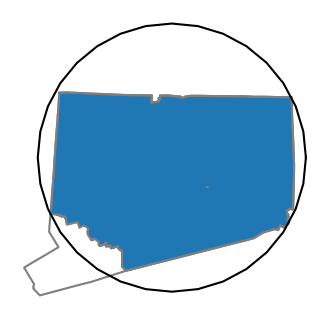

In [36]:
fig, ax = plt.subplots(figsize=(4,4))
circumference_points = state_min_radius*np.vstack([np.cos(radians), np.sin(radians)]).T
ax.set_axis_off()
diss_1.boundary.plot(ax=ax, color="tab:grey")

diss_2 = df_2.dissolve()
diss_2.boundary.plot(ax=ax, color="tab:grey")
diss_2.plot(ax=ax, color="C0")
plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="black")


0.5820863683639754
190.0 80.0


0.6314

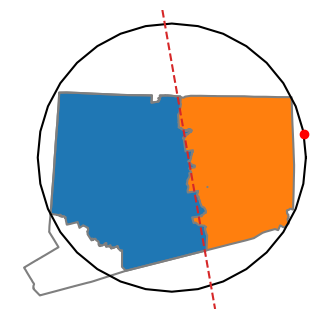

In [37]:
optimal_choice = degrees_tracker.iloc[0]
print(optimal_choice['compactness'])
piece = optimal_choice['pieces'] - 2 + (1 * optimal_choice['inclusive'])
ax_line_lon = df_2.loc[piece]['RP_LON']
ax_line_lat = df_2.loc[piece]['RP_LAT']

fig, ax = plt.subplots(figsize=(4,4))
circumference_points = state_min_radius*np.vstack([np.cos(radians), np.sin(radians)]).T

ax.set_axis_off()
diss_1 = df_1.dissolve()
diss_1.boundary.plot(ax=ax, color='tab:grey')

diss_2 = df_2.dissolve()
diss_2.plot(ax=ax, color="C1")

diss_3 = df_3.dissolve()
diss_3.boundary.plot(ax=ax, color="tab:grey")
diss_3.plot(ax=ax, color="C0")

d_ =  optimal_choice['degree']
slope = tangent_slopes[np.where(degrees == d_)][0]
# ax.axline((origin[0], origin[1]), slope=-1/slope, color='C3', linestyle="--")

d_2 = 270 - d_
d_2 = d_2 + 360.0 if d_2 < 0 else d_2
print(d_,d_2)
tangent_point = [state_min_radius * np.sin(radians[np.where(degrees == d_2)])[0],state_min_radius * np.cos(radians[np.where(degrees == d_2)])[0]] 
tangent_point = np.array(tangent_point) + origin

plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="black")
ax.axline((ax_line_lon, ax_line_lat), slope=slope, color='C3', linestyle="--")
ax.plot(tangent_point[0],tangent_point[1],'ro')

# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
round(reock_score(diss_2),4)

In [38]:

step = 3
# Loop through each degree point

df_3["INDEX_"] = df_3.index
points = df_3[["RP_LON", "RP_LAT"]].to_numpy()

# Create circle of remaining pieces
state_dissolved = df_3.dissolve()
state_min_radius = state_dissolved.geometry.minimum_bounding_radius()[0]
state_min_circle = state_dissolved.geometry.minimum_bounding_circle()[0]
state_min_circle_o = state_min_circle.centroid
origin = np.array([state_min_circle_o.x, state_min_circle_o.y])



degrees_tracker = []
for degree in tqdm(degrees):
    df_3 = df_3.sort_values(by="INDEX_").reset_index(drop=True)
    df_3["NEW_DISTRICT_"] = 0

    rotated_points = rotate_vector(points, 360 - degree, origin)
    df_3["ROTATED_LON"] = rotated_points[:, 0]
    df_3 = df_3.sort_values(by="ROTATED_LON").reset_index(drop=True)
    i = 0
    captured_pop = 0
    while captured_pop < target_pop:
        captured_pop += df_3.loc[i, pop]
        i += 1
    # Check for Inclusivity
    pop_check1 = df_3.iloc[: i - 1][pop].sum()
    pop_check2 = df_3.iloc[:i][pop].sum()
    inclusive = (
        True
        if abs(pop_check1 - target_pop) > abs(pop_check2 - target_pop)
        else False
    )
    if inclusive:
        df_3.loc[: i - 1, "NEW_DISTRICT_"] = 1
    else:
        df_3.loc[: i - 2, "NEW_DISTRICT_"] = 1
    # df_3.dissolve(by="NEW_DISTRICT_").reset_index().plot(column="NEW_DISTRICT_")
    

    df_a = df_3.loc[df_3["NEW_DISTRICT_"] == 1].copy().reset_index(drop=True)
    df_b = df_3.loc[df_3["NEW_DISTRICT_"] != 1].copy().reset_index(drop=True)

    df_a_compactness = reock_score(df_a.dissolve())
    df_b_compactness = reock_score(df_b.dissolve())
    mean_compactness = (df_a_compactness + df_b_compactness) / 2

    degrees_tracker.append(
        {
            "degree": degree,
            "pieces": i,
            "inclusive": inclusive,
            "population": captured_pop,
            "compactness": mean_compactness,
        }
    )

degrees_tracker = pd.DataFrame(degrees_tracker)
degrees_tracker = degrees_tracker.sort_values(
    by="compactness", ascending=False
).reset_index(drop=True)
optimal_choice = degrees_tracker.iloc[0]

df_3 = df_3.sort_values(by="INDEX_").reset_index(drop=True)
rotated_points = rotate_vector(points, 360 - optimal_choice["degree"], origin)
df_3["ROTATED_LON"] = rotated_points[:, 0]
df_3 = df_3.sort_values(by="ROTATED_LON").reset_index(drop=True)
if optimal_choice["inclusive"]:
    df_3.loc[: optimal_choice["pieces"] - 1, "DISTRICT_"] = step
else:
    df_3.loc[: optimal_choice["pieces"] - 2, "DISTRICT_"] = step

holder.append(df_3.loc[df_3["DISTRICT_"] == step])
df_4 = df_3.loc[df_3["DISTRICT_"] == 0]  # So far unused.


c:\Users\yagne\.conda\envs\gm6\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
100%|██████████| 36/36 [00:18<00:00,  1.97it/s]


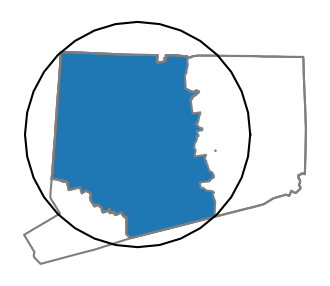

In [39]:
fig, ax = plt.subplots(figsize=(4,4))
circumference_points = state_min_radius*np.vstack([np.cos(radians), np.sin(radians)]).T
ax.set_axis_off()
# diss_2 = df_2.dissolve()
diss_1.boundary.plot(ax=ax, color="tab:grey")
diss_2.boundary.plot(ax=ax, color="tab:grey")

# diss_3 = df_3.dissolve()
diss_3.boundary.plot(ax=ax, color="tab:grey")
diss_3.plot(ax=ax, color="C0")


plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="black")


0.555544092363721
120.0 150.0


0.5986

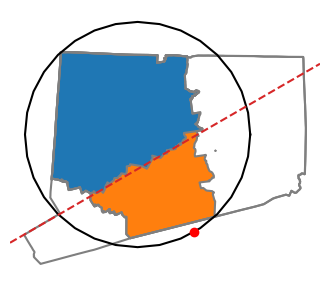

In [40]:
optimal_choice = degrees_tracker.iloc[0]
print(optimal_choice['compactness'])
piece = optimal_choice['pieces'] - 2 + (1 * optimal_choice['inclusive'])
ax_line_lon = df_3.loc[piece]['RP_LON']
ax_line_lat = df_3.loc[piece]['RP_LAT']

fig, ax = plt.subplots(figsize=(4,4))
circumference_points = state_min_radius*np.vstack([np.cos(radians), np.sin(radians)]).T

ax.set_axis_off()
diss_1.boundary.plot(ax=ax, color="tab:grey")
diss_2.boundary.plot(ax=ax, color="tab:grey")

diss_3.plot(ax=ax, color="C1")
diss_3.boundary.plot(ax=ax, color="tab:grey")

diss_4 = df_4.dissolve()
diss_4.boundary.plot(ax=ax, color="tab:grey")
diss_4.plot(ax=ax, color="C0")

d_ =  optimal_choice['degree']
slope = tangent_slopes[np.where(degrees == d_)][0]
# ax.axline((origin[0], origin[1]), slope=-1/slope, color='C3', linestyle="--")

d_2 = 270 - d_
d_2 = d_2 + 360.0 if d_2 < 0 else d_2
print(d_,d_2)
tangent_point = [state_min_radius * np.sin(radians[np.where(degrees == d_2)])[0],state_min_radius * np.cos(radians[np.where(degrees == d_2)])[0]] 
tangent_point = np.array(tangent_point) + origin

plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="black")
ax.axline((ax_line_lon, ax_line_lat), slope=slope, color='C3', linestyle="--")
ax.plot(tangent_point[0],tangent_point[1],'ro')

# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
round(reock_score(diss_4),4)

In [41]:

step = 4
# Loop through each degree point

df_4["INDEX_"] = df_4.index
points = df_4[["RP_LON", "RP_LAT"]].to_numpy()

# Create circle of remaining pieces
state_dissolved = df_4.dissolve()
state_min_radius = state_dissolved.geometry.minimum_bounding_radius()[0]
state_min_circle = state_dissolved.geometry.minimum_bounding_circle()[0]
state_min_circle_o = state_min_circle.centroid
origin = np.array([state_min_circle_o.x, state_min_circle_o.y])



degrees_tracker = []
for degree in tqdm(degrees):
    df_4 = df_4.sort_values(by="INDEX_").reset_index(drop=True)
    df_4["NEW_DISTRICT_"] = 0

    rotated_points = rotate_vector(points, 360 - degree, origin)
    df_4["ROTATED_LON"] = rotated_points[:, 0]
    df_4 = df_4.sort_values(by="ROTATED_LON").reset_index(drop=True)
    i = 0
    captured_pop = 0
    while captured_pop < target_pop:
        captured_pop += df_4.loc[i, pop]
        i += 1
    # Check for Inclusivity
    pop_check1 = df_4.iloc[: i - 1][pop].sum()
    pop_check2 = df_4.iloc[:i][pop].sum()
    inclusive = (
        True
        if abs(pop_check1 - target_pop) > abs(pop_check2 - target_pop)
        else False
    )
    if inclusive:
        df_4.loc[: i - 1, "NEW_DISTRICT_"] = 1
    else:
        df_4.loc[: i - 2, "NEW_DISTRICT_"] = 1
    # df_4.dissolve(by="NEW_DISTRICT_").reset_index().plot(column="NEW_DISTRICT_")
    

    df_a = df_4.loc[df_4["NEW_DISTRICT_"] == 1].copy().reset_index(drop=True)
    df_b = df_4.loc[df_4["NEW_DISTRICT_"] != 1].copy().reset_index(drop=True)

    df_a_compactness = reock_score(df_a.dissolve())
    df_b_compactness = reock_score(df_b.dissolve())
    mean_compactness = (df_a_compactness + df_b_compactness) / 2

    degrees_tracker.append(
        {
            "degree": degree,
            "pieces": i,
            "inclusive": inclusive,
            "population": captured_pop,
            "compactness": mean_compactness,
        }
    )

degrees_tracker = pd.DataFrame(degrees_tracker)
degrees_tracker = degrees_tracker.sort_values(
    by="compactness", ascending=False
).reset_index(drop=True)
optimal_choice = degrees_tracker.iloc[0]

df_4 = df_4.sort_values(by="INDEX_").reset_index(drop=True)
rotated_points = rotate_vector(points, 360 - optimal_choice["degree"], origin)
df_4["ROTATED_LON"] = rotated_points[:, 0]
df_4 = df_4.sort_values(by="ROTATED_LON").reset_index(drop=True)
if optimal_choice["inclusive"]:
    df_4.loc[: optimal_choice["pieces"] - 1, "DISTRICT_"] = step
else:
    df_4.loc[: optimal_choice["pieces"] - 2, "DISTRICT_"] = step

holder.append(df_4.loc[df_4["DISTRICT_"] == step])
df_5 = df_4.loc[df_4["DISTRICT_"] == 0]  # So far unused.


c:\Users\yagne\.conda\envs\gm6\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
100%|██████████| 36/36 [00:12<00:00,  2.97it/s]


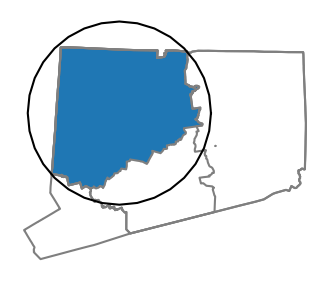

In [42]:
fig, ax = plt.subplots(figsize=(4,4))
circumference_points = state_min_radius*np.vstack([np.cos(radians), np.sin(radians)]).T
ax.set_axis_off()
diss_1.boundary.plot(ax=ax, color="tab:grey")
diss_2.boundary.plot(ax=ax, color="tab:grey")
diss_3.boundary.plot(ax=ax, color="tab:grey")

diss_4.boundary.plot(ax=ax, color="tab:grey")
diss_4.plot(ax=ax, color="C0")

plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="black")


0.5562818187021007
20.0 250.0


0.4907

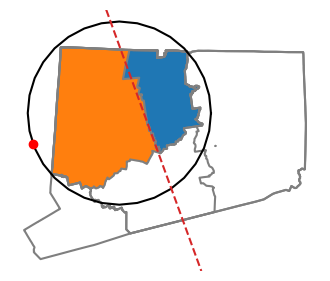

In [43]:
optimal_choice = degrees_tracker.iloc[0]
print(optimal_choice['compactness'])
piece = optimal_choice['pieces'] - 2 + (1 * optimal_choice['inclusive'])
ax_line_lon = df_4.loc[piece]['RP_LON']
ax_line_lat = df_4.loc[piece]['RP_LAT']

fig, ax = plt.subplots(figsize=(4,4))
circumference_points = state_min_radius*np.vstack([np.cos(radians), np.sin(radians)]).T

ax.set_axis_off()
diss_1.boundary.plot(ax=ax, color="tab:grey")
diss_2.boundary.plot(ax=ax, color="tab:grey")
diss_3.boundary.plot(ax=ax, color="tab:grey")

diss_4.plot(ax=ax, color="C1")
diss_4.boundary.plot(ax=ax, color="tab:grey")

diss_5 = df_5.dissolve()
diss_5.boundary.plot(ax=ax, color="tab:grey")
diss_5.plot(ax=ax, color="C0")

d_ =  optimal_choice['degree']
slope = tangent_slopes[np.where(degrees == d_)][0]
# ax.axline((origin[0], origin[1]), slope=-1/slope, color='C3', linestyle="--")

d_2 = 270 - d_
d_2 = d_2 + 360.0 if d_2 < 0 else d_2
print(d_,d_2)
tangent_point = [state_min_radius * np.sin(radians[np.where(degrees == d_2)])[0],state_min_radius * np.cos(radians[np.where(degrees == d_2)])[0]] 
tangent_point = np.array(tangent_point) + origin

plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="black")
ax.axline((ax_line_lon, ax_line_lat), slope=slope, color='C3', linestyle="--")
ax.plot(tangent_point[0],tangent_point[1],'ro')

# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
round(reock_score(diss_5),4)

In [47]:
step = 5
# Loop through each degree point

df_5["INDEX_"] = df_5.index
points = df_5[["RP_LON", "RP_LAT"]].to_numpy()

# Create circle of remaining pieces
state_dissolved = df_5.dissolve()
state_min_radius = state_dissolved.geometry.minimum_bounding_radius()[0]
state_min_circle = state_dissolved.geometry.minimum_bounding_circle()[0]
state_min_circle_o = state_min_circle.centroid
origin = np.array([state_min_circle_o.x, state_min_circle_o.y])
holder.append(df_5)


c:\Users\yagne\.conda\envs\gm6\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


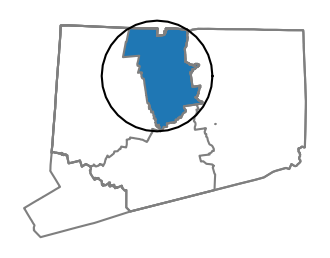

In [48]:
fig, ax = plt.subplots(figsize=(4,4))
circumference_points = state_min_radius*np.vstack([np.cos(radians), np.sin(radians)]).T
ax.set_axis_off()
diss_1.boundary.plot(ax=ax, color="tab:grey")
diss_2.boundary.plot(ax=ax, color="tab:grey")
diss_3.boundary.plot(ax=ax, color="tab:grey")
diss_4.boundary.plot(ax=ax, color="tab:grey")
diss_5.boundary.plot(ax=ax, color="tab:grey")
diss_5.plot(ax=ax, color="C0")

plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="black")


<Axes: >

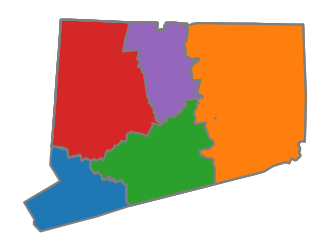

In [50]:
fig, ax = plt.subplots(figsize=(4,4))
ax.set_axis_off()

diss_1.boundary.plot(ax=ax, color="tab:grey")
diss_1.plot(ax=ax, color="C0")
diss_2.boundary.plot(ax=ax, color="tab:grey")
diss_2.plot(ax=ax, color="C1")
diss_3.boundary.plot(ax=ax, color="tab:grey")
diss_3.plot(ax=ax, color="C2")
diss_4.boundary.plot(ax=ax, color="tab:grey")
diss_4.plot(ax=ax, color="C3")
diss_5.boundary.plot(ax=ax, color="tab:grey")
diss_5.plot(ax=ax, color="C4")